In [ ]:
import torch
from torchvision import datasets,transforms,models
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!git clone https://github.com/jaddoescad/ants_and_bees

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [ ]:
!ls ants_and_bees

train  val


In [ ]:
transform_train = transforms.Compose([transforms.Resize([224,224]),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomAffine(0,shear = 10,scale=(.8,1.2)),
                                transforms.ColorJitter(brightness =1,saturation = 1,contrast = 1),
                                transforms.ToTensor(),
                                transforms.Normalize([.5,],[.5,])])


transform = transforms.Compose([transforms.Resize([224,224]),
                                transforms.ToTensor(),
                                transforms.Normalize([.5,],[.5,])])
                                

training_dataset = datasets.ImageFolder('ants_and_bees/train',transform =transform_train)
validation_dataset = datasets.ImageFolder('ants_and_bees/val',transform =transform)

training_loader = torch.utils.data.DataLoader(training_dataset,batch_size = 20,shuffle =True)
validation_loader = torch.utils.data.DataLoader(validation_dataset,batch_size = 20,shuffle =False)

In [ ]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)
  print(image.shape)
  image = image*np.array([.5,.5,.5])+np.array([.5,.5,.5])
  image = image.clip(0,1)
  return image

In [ ]:
classes = ('ant','bee')

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


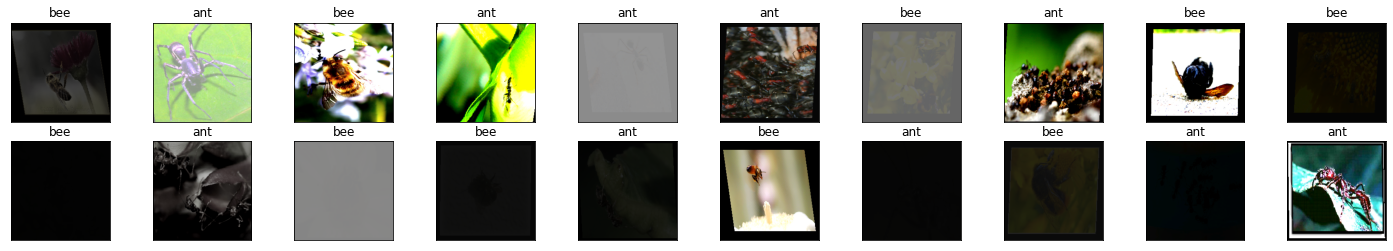

In [ ]:
dataiter  = iter(training_loader)
images,labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [ ]:
model = models.vgg16(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in model.features.parameters():
  param.requires_grad = False

In [ ]:
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs,len(classes))
model.classifier[6] = last_layer
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=.0001)

In [ ]:
epochs =10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for i in range(epochs):
  running_loss = 0.0
  running_corrects= 0.0
  val_running_loss = 0.0
  val_running_corrects= 0.0
  for inputs,labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    loss = criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _,preds = torch.max(outputs,1)
   
    running_loss += loss.item()
    running_corrects += torch.sum(preds==labels.data)

  else:
    with torch.no_grad():

      for val_inputs,val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs,val_labels)

        _,val_preds = torch.max(val_outputs,1)

        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds==val_labels.data)

    epoch_loss = running_loss/len(training_loader.dataset)*100
    epoch_acc =running_corrects.float()/len(training_loader.dataset)*100
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    print('epoch :',i+1)
    print('training loss : {:.4f},training_acc :{:.4f}'.format(epoch_loss,epoch_acc.item()))

    val_epoch_loss = val_running_loss/len(validation_loader.dataset)*100
    val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)*100
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('validation loss : {:.4f},val_acc : {:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))


    

epoch : 1
training loss : 2.9849,training_acc :66.8033
validation loss : 1.4199,val_acc : 90.8497
epoch : 2
training loss : 1.8951,training_acc :84.8361
validation loss : 1.3729,val_acc : 91.5033
epoch : 3
training loss : 1.4529,training_acc :85.6557
validation loss : 1.1925,val_acc : 94.1176
epoch : 4
training loss : 1.5751,training_acc :85.6557
validation loss : 1.5537,val_acc : 92.1569
epoch : 5
training loss : 0.9135,training_acc :89.7541
validation loss : 1.7319,val_acc : 92.1569
epoch : 6
training loss : 1.1874,training_acc :89.3443
validation loss : 1.5928,val_acc : 92.1569
epoch : 7
training loss : 1.3852,training_acc :86.4754
validation loss : 1.4720,val_acc : 90.8497
epoch : 8
training loss : 1.3457,training_acc :86.8852
validation loss : 1.7260,val_acc : 90.8497
epoch : 9
training loss : 1.3320,training_acc :88.1148
validation loss : 1.5788,val_acc : 92.1569
epoch : 10
training loss : 0.9547,training_acc :91.8033
validation loss : 1.7714,val_acc : 91.5033


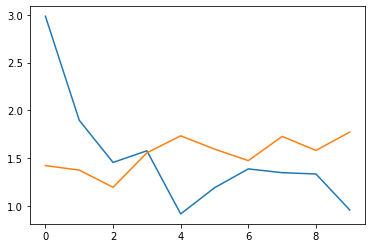

In [ ]:
plt.plot(running_loss_history)
plt.plot(val_running_loss_history)

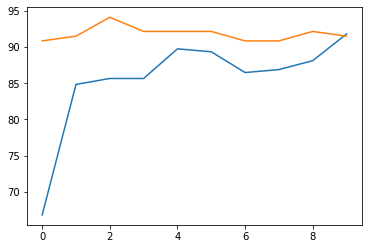

In [ ]:
plt.plot(running_corrects_history)
plt.plot(val_running_corrects_history)

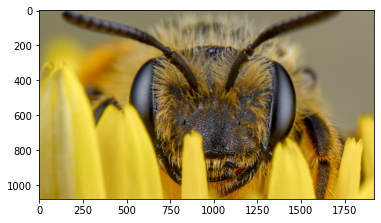

In [ ]:
import requests
from PIL import Image

url = 'https://www.scitecheuropa.eu/wp-content/uploads/2019/09/Bee-hiding.jpg'

response = requests.get(url,stream = True)
img = Image.open(response.raw)
plt.imshow(img)

(224, 224, 3)


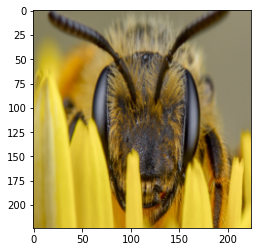

In [ ]:
import PIL
img = transform(img)
plt.imshow(im_convert(img))

In [ ]:
image = img.to(device).unsqueeze(0)
output = model(image)
_,pred = torch.max(output,1)
print(classes[pred.item()])

bee


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


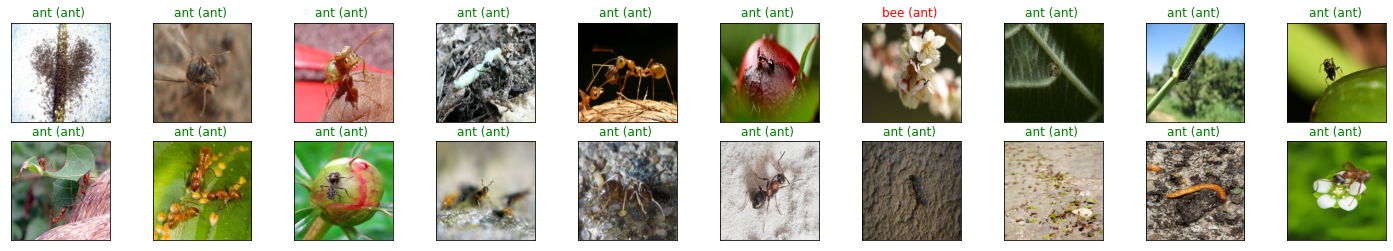

In [ ]:
dataiter2  = iter(validation_loader)
images,labels = dataiter2.next()
images_ = images.to(device)
labels = labels.to(device)
fig = plt.figure(figsize=(25,4))
output = model(images_)
_,preds = torch.max(output,1)
for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({}) ".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color = ("green" if preds[idx].item()==labels[idx] else "red"))